In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import learning_curve,cross_val_score,validation_curve,train_test_split,KFold

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor,plot_importance
import joblib


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [15]:
#functions
def remove_by_vif(X,vif=5):
    """Remove columns from X whose VIF is greater than supplied 'vif'
    Parameters:
        X:array or dataframe containing data excluding target variable
        vif: int or float of limiting value of VIF
    Note:
        This function changes X inplace
    """
    
    
    removed=[]
    for i in range(len(X.columns)):
        l = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        s=pd.Series(index=X.columns,data=l).sort_values(ascending=False)
        if s.iloc[0]>vif:
            X.drop(s.index[0],axis=1,inplace=True)
            print(s.index[0],', VIF: ',s.iloc[0])
            removed.append(s.index[0])
        else:
            break
    return removed

In [16]:
def plot_validation_curve(scores,param_range,param_name,scoring='r2'):
    """This function plot validation curve.
    
    Parameters:
        scores: scores obtained from validation_curve() method
        param_range: list of range of parameters passed as 'param_range' in validation_curve() method
        scoring: str
    """
    n=len(param_range)
    if scoring=='r2':
        train_score=[scores[0][i].mean() for i in range (0,n)]
        test_score=[scores[1][i].mean() for i in range (0,n)]
    elif scoring=='neg_mean_squared_error':
        train_score=[np.sqrt(-scores[0][i].mean()) for i in range (0,n)]
        test_score=[np.sqrt(-scores[1][i].mean()) for i in range (0,n)]

    fig=plt.figure(figsize=(8,6))
    plt.plot(param_range,train_score,label='Train')
    plt.plot(param_range,test_score,label='Test')
    plt.xticks=param_range
    plt.title("Validation curve of {}".format(param_name),size=12)
    plt.legend()

In [17]:
train = pd.read_csv("train_NIR5Yl1.csv")
train.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes
0,52664,a,3942.0,2.0,155623,7855.0,42.0
1,327662,a,26046.0,12.0,21781,55801.0,1175.0
2,468453,c,1358.0,4.0,56177,8067.0,60.0
3,96996,a,264.0,3.0,168793,27064.0,9.0
4,131465,c,4271.0,4.0,112223,13986.0,83.0


In [18]:
train.shape

(330045, 7)

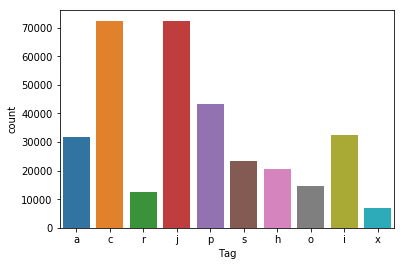

In [19]:
sns.countplot('Tag',data=train)
plt.show()


In [20]:
num_features=['Reputation', 'Answers', 'Views']

In [21]:
#1. Getting polynomial features and selecting only newly created features
poly=PolynomialFeatures(degree=2,include_bias=False)
tmp=pd.DataFrame(poly.fit_transform(train[num_features])).loc[:,len(num_features):]
train=train.join(tmp)

In [22]:
train.head(2)

,ID,Tag,Reputation,Answers,Username,Views,Upvotes,3,4,5,6,7,8
0,52664,a,3942.0,2.0,155623,7855.0,42.0,15539364.0,7884.0,3.096441e+07,4.0,15710.0,6.170102e+07
1,327662,a,26046.0,12.0,21781,55801.0,1175.0,678394116.0,312552.0,1.453393e+09,144.0,669612.0,3.113752e+09


In [23]:
#2. Tag-wise mean of numberical features
tmp=train.groupby('Tag')[num_features].mean()
tmp.columns=tmp.columns+'_mean'
train=pd.merge(train,tmp.reset_index(),how='left',on='Tag')

In [24]:
train.head(2)

,ID,Tag,Reputation,Answers,Username,Views,Upvotes,3,4,5,6,7,8,Reputation_mean,Answers_mean,Views_mean
0,52664,a,3942.0,2.0,155623,7855.0,42.0,15539364.0,7884.0,3.096441e+07,4.0,15710.0,6.170102e+07,6065.168102,4.259189,31800.916327
1,327662,a,26046.0,12.0,21781,55801.0,1175.0,678394116.0,312552.0,1.453393e+09,144.0,669612.0,3.113752e+09,6065.168102,4.259189,31800.916327


In [25]:
# Username wise count of upvotes. Fill nulls with 0
uname_count=train.groupby('Username')['Upvotes'].count().reset_index()
uname_count.rename(columns={'Upvotes':'User_Upvote_Count'},inplace=True)
train=pd.merge(train,uname_count,how='left',on='Username')
train['User_Upvote_Count'].fillna(0,inplace=True)

In [26]:
train.head(2)

,ID,Tag,Reputation,Answers,Username,Views,Upvotes,3,4,5,6,7,8,Reputation_mean,Answers_mean,Views_mean,User_Upvote_Count
0,52664,a,3942.0,2.0,155623,7855.0,42.0,15539364.0,7884.0,3.096441e+07,4.0,15710.0,6.170102e+07,6065.168102,4.259189,31800.916327,19
1,327662,a,26046.0,12.0,21781,55801.0,1175.0,678394116.0,312552.0,1.453393e+09,144.0,669612.0,3.113752e+09,6065.168102,4.259189,31800.916327,2


In [27]:
train['uv']=train['Upvotes']/train['Views']
uname_uv=train.groupby('Username')['uv'].mean().reset_index()
uname_uv.rename(columns={'uv':'User_Upvote_Views_Mean'},inplace=True)
train=pd.merge(train,uname_uv,how='left',on='Username')
train['User_Upvote_Views_Mean'].fillna(0,inplace=True)

train.drop('uv',axis=1,inplace=True)

In [28]:
train.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes,3,4,5,6,7,8,Reputation_mean,Answers_mean,Views_mean,User_Upvote_Count,User_Upvote_Views_Mean
0,52664,a,3942.0,2.0,155623,7855.0,42.0,15539364.0,7884.0,3.096441e+07,4.0,15710.0,6.170102e+07,6065.168102,4.259189,31800.916327,19,0.008671
1,327662,a,26046.0,12.0,21781,55801.0,1175.0,678394116.0,312552.0,1.453393e+09,144.0,669612.0,3.113752e+09,6065.168102,4.259189,31800.916327,2,0.021218
2,468453,c,1358.0,4.0,56177,8067.0,60.0,1844164.0,5432.0,1.095499e+07,16.0,32268.0,6.507649e+07,10566.420657,4.047697,26746.676875,1,0.007438
3,96996,a,264.0,3.0,168793,27064.0,9.0,69696.0,792.0,7.144896e+06,9.0,81192.0,7.324601e+08,6065.168102,4.259189,31800.916327,3,0.000737
4,131465,c,4271.0,4.0,112223,13986.0,83.0,18241441.0,17084.0,5.973421e+07,16.0,55944.0,1.956082e+08,10566.420657,4.047697,26746.676875,3,0.005037


In [29]:
#3. One hot encoding of Tag
dummies=pd.get_dummies(train['Tag'],drop_first=True)
train=pd.concat([train,dummies],axis=1)
train.drop('Tag',axis=1,inplace=True)

In [30]:
train.head(2)

,ID,Reputation,Answers,Username,Views,Upvotes,3,4,5,6,...,User_Upvote_Views_Mean,c,h,i,j,o,p,r,s,x
0,52664,3942.0,2.0,155623,7855.0,42.0,15539364.0,7884.0,3.096441e+07,4.0,...,0.008671,0,0,0,0,0,0,0,0,0
1,327662,26046.0,12.0,21781,55801.0,1175.0,678394116.0,312552.0,1.453393e+09,144.0,...,0.021218,0,0,0,0,0,0,0,0,0


In [31]:
X=train.drop('Upvotes',axis=1)
y=train['Upvotes']

In [33]:
X.head(2)

,ID,Reputation,Answers,Username,Views,3,4,5,6,7,...,User_Upvote_Views_Mean,c,h,i,j,o,p,r,s,x
0,52664,3942.0,2.0,155623,7855.0,15539364.0,7884.0,3.096441e+07,4.0,15710.0,...,0.008671,0,0,0,0,0,0,0,0,0
1,327662,26046.0,12.0,21781,55801.0,678394116.0,312552.0,1.453393e+09,144.0,669612.0,...,0.021218,0,0,0,0,0,0,0,0,0


In [34]:
#4. Check multicolinearity
removed_by_vif=remove_by_vif(X.copy())

X=X.drop(removed_by_vif,axis=1)

x , VIF:  9007199254740992.0


C:\Users\Shrikant\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


h , VIF:  inf
Views_mean , VIF:  46.86720979955085
Reputation_mean , VIF:  17.194673421418152
7 , VIF:  9.241982076408794


In [35]:
X.drop('ID',axis=1,inplace=True)

In [36]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=60)

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=60)

In [38]:
#scaling
std=StandardScaler()
X_train_scaled=pd.DataFrame(std.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
X_val_scaled=pd.DataFrame(std.transform(X_val),columns=X_val.columns,index=X_val.index)
X_test_scaled=pd.DataFrame(std.transform(X_test),columns=X_test.columns,index=X_test.index)

C:\Users\Shrikant\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Shrikant\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Shrikant\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\Shrikant\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


In [39]:
scoring='neg_mean_squared_error'

### Linear Regression

In [40]:
lr=LinearRegression()
scores=cross_val_score(lr,X_train_scaled,y_train,n_jobs=-1,cv=5,scoring=scoring)
print('RMSE: ',np.sqrt(-scores).mean())

RMSE:  1382.585517606471


In [41]:
lr.fit(X_train_scaled,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [42]:
# Result on test
y_train_pred=lr.predict(X_train_scaled)
y_val_pred=lr.predict(X_val_scaled)
y_pred_lr=np.append(y_train_pred,y_val_pred)
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_val,y_val_pred)))

Train RMSE: 1240.5516265519736
Test RMSE: 788.5062304987126


In [43]:
# Baseline Model
xgb=XGBRegressor(random_state=50)
xgb.fit(X_train_scaled,y_train)
y_train_pred=xgb.predict(X_train_scaled)
y_val_pred=xgb.predict(X_val_scaled)
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_val,y_val_pred)))

Train RMSE: 607.939006737356
Test RMSE: 898.3695564791359


In [44]:
# Bayesian Optimization
opt = BayesSearchCV(
    estimator = XGBRegressor(
        n_jobs = -1,
        tree_method='approx'
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 20),
        'max_depth': (3, 5),
#         'max_delta_step': (0, 20),
        'subsample': (0.1, 1.0, 'uniform'),
        'colsample_bytree': (0.1, 1.0, 'uniform'),
        'colsample_bylevel': (0.1, 1.0, 'uniform'),
        'reg_lambda': (1e-3, 1000, 'log-uniform'),
        'reg_alpha': (1e-3, 1.0, 'log-uniform'),
#         'gamma': (1e-9, 0.5, 'log-uniform'),
        'base_score':((1e-4, 0.5, 'log-uniform'))
    },    
    scoring = scoring,
    cv =3,
    n_jobs = -1,
    refit = True,
    random_state = 42
)

opt.fit(X_train_scaled,y_train)

BayesSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='approx'),
       fit_params=None, iid=True, n_iter=50, n_jobs=-1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=42,
       refit=True, return_train_score=False,
       scoring='neg_mean_squared_error',
       search_spaces={'learning_rate': (0.01, 1.0, 'log-uniform'), 'min_child_weight': (0, 20), 'max_depth': (3, 5), 'subsample': (0.1, 1.0, 'uniform'), 'colsample_bytree': (0.1, 1.0, 'uniform'), 'colsample_bylevel': (0.1, 1.0, 'uniform'), 'reg_lambda': (0.001, 1000, 'log-uniform'), 'reg_alpha': (0.001, 1.0, 

In [45]:


opt.best_params_



{'base_score': 0.0048498902366922135,
 'colsample_bylevel': 0.6173216144659593,
 'colsample_bytree': 0.8331307038520519,
 'learning_rate': 0.10768174522203376,
 'max_depth': 4,
 'min_child_weight': 1,
 'reg_alpha': 0.015083772848150384,
 'reg_lambda': 0.002735789383183587,
 'subsample': 0.3247029778080074}

In [46]:
#Tuned Model
xgb=XGBRegressor(random_state=51,n_jobs=-1,**opt.best_params_)
xgb.fit(X_train_scaled,y_train)
y_train_pred=xgb.predict(X_train_scaled)
y_val_pred=xgb.predict(X_val_scaled)
y_pred_xgb=np.append(y_train_pred,y_val_pred)
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_val,y_val_pred)))

Train RMSE: 594.5644568813723
Test RMSE: 894.8474841036207


In [47]:
#cross-val-score
xgb=XGBRegressor(random_state=50,**opt.best_params_)
scores=cross_val_score(xgb,X_train_scaled,y_train,n_jobs=-1,cv=3,scoring=scoring)
print('RMSE: ',np.sqrt(-scores).mean())

RMSE:  1167.1075394509069


In [48]:
#Feature importance
xgb=XGBRegressor(random_state=51,n_jobs=-1,**opt.best_params_)
xgb.fit(X_train_scaled,y_train)
pd.DataFrame(xgb.feature_importances_,index=X_train.columns).sort_values(0,ascending=False).head()

,0
5,0.235125
Reputation,0.156430
Views,0.138196
4,0.129559
Answers,0.104607


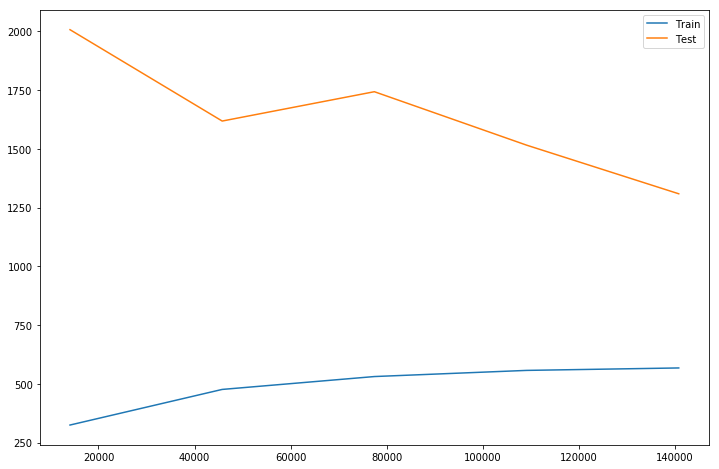

In [49]:
xgb=XGBRegressor(random_state=51,**opt.best_params_)
lc=learning_curve(xgb,X_train_scaled,y_train,cv=3,n_jobs=-1,scoring=scoring)
size=lc[0]
train_score=[-lc[1][i].mean() for i in range (0,5)]
test_score=[-lc[2][i].mean() for i in range (0,5)]
fig=plt.figure(figsize=(12,8))
plt.plot(size,np.sqrt(train_score),label='Train')
plt.plot(size,np.sqrt(test_score),label="Test")
plt.legend()
#Overfit

In [50]:
y_pred_stack=(y_pred_lr+y_pred_xgb)/2

In [51]:
y_train_pred=y_pred_stack[:len(y_train)]
y_val_pred=y_pred_stack[len(y_train):]
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_val,y_val_pred)))

Train RMSE: 827.521955841061
Test RMSE: 818.5357551636881


In [52]:
X_train_1=pd.concat([X_train_scaled,X_val_scaled])
y_train_1=pd.concat([y_train,y_val])

In [53]:
lr.fit(X_train_1,y_train_1)
y_pred_lr=lr.predict(X_test_scaled)

In [54]:
# XGB
xgb=XGBRegressor(random_state=51,n_jobs=-1,**opt.best_params_)
xgb.fit(X_train_1,y_train_1)
y_pred_xgb=xgb.predict(X_test_scaled)
print('Test RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_xgb)))

Test RMSE: 1171.017440694157


In [55]:
#Stack
y_pred_stack=(y_pred_lr+y_pred_xgb)/2
print('Test RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_stack)))

Test RMSE: 934.8365735303153


In [56]:
test=pd.read_csv('test_8i3B3FC.csv')

In [57]:
# Data preparation
X_scaled=pd.DataFrame(std.fit_transform(X),columns=X.columns,index=X.index)

# Polynomial Features
tmp=pd.DataFrame(poly.transform(test[num_features])).loc[:,len(num_features):]
test=test.join(tmp)

#Tag wise mean of num features
tmp=test.groupby('Tag')[num_features].mean()
tmp.columns=tmp.columns+'_mean'
test=pd.merge(test,tmp.reset_index(),how='left',on='Tag')

# Userwise upvotes count
test=pd.merge(test,uname_count,how='left',on='Username')
test['User_Upvote_Count'].fillna(0,inplace=True)

# Userwise upvotes,views mean
test=pd.merge(test,uname_uv,how='left',on='Username')
test['User_Upvote_Views_Mean'].fillna(0,inplace=True)

# One hot encoding of Tag
dummies=pd.get_dummies(test['Tag'],drop_first=True)
test=pd.concat([test,dummies],axis=1)
test.drop('Tag',axis=1,inplace=True)

# remove columns with high vif
test_ids=test['ID']
test.drop(['ID']+removed_by_vif,axis=1,inplace=True)

#scaling
test_scaled=pd.DataFrame(std.transform(test),columns=test.columns)

C:\Users\Shrikant\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Shrikant\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Shrikant\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


In [58]:
lr=LinearRegression()
xgb=XGBRegressor(random_state=51,n_jobs=-1,**opt.best_params_)
std=StandardScaler()
lr.fit(X_scaled,y)
xgb.fit(X_scaled,y)

XGBRegressor(base_score=0.0048498902366922135, booster='gbtree',
       colsample_bylevel=0.6173216144659593,
       colsample_bytree=0.8331307038520519, gamma=0,
       learning_rate=0.10768174522203376, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=51,
       reg_alpha=0.015083772848150384, reg_lambda=0.002735789383183587,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.3247029778080074)

In [59]:
y_pred_lr=lr.predict(test_scaled)
y_pred_xgb=xgb.predict(test_scaled)
y_pred_stacked=(y_pred_lr+y_pred_xgb)/2

In [60]:
submission=pd.DataFrame(index=test_ids)
submission['Upvotes']=list(map(int,y_pred_stacked))

In [61]:
submission.to_csv('Submission.csv')

### Approach 2

In [9]:
train = train.drop(train[train.Views > 3000000].index) # remove the rows where View greater than 3000000


In [10]:
labelencoder_X = LabelEncoder()
train['Tag'] = labelencoder_X.fit_transform(train['Tag'])
train.drop(['ID','Username'], axis=1,inplace =True)
target = train['Upvotes']

In [12]:
from sklearn.preprocessing import Binarizer
bn = Binarizer(threshold=7)
pd_watched = bn.transform([train['Answers']])[0]
train['pd_watched'] = pd_watched

In [18]:
feature_names = [x for x in train.columns if x not in ['Upvotes']]

In [19]:
feature_names

['Tag', 'Reputation', 'Answers', 'Views', 'pd_watched']

In [20]:
train.head()

,Tag,Reputation,Answers,Views,Upvotes,pd_watched
0,0,3942.0,2.0,7855.0,42.0,0.0
1,0,26046.0,12.0,55801.0,1175.0,1.0
2,1,1358.0,4.0,8067.0,60.0,0.0
3,0,264.0,3.0,27064.0,9.0,0.0
4,1,4271.0,4.0,13986.0,83.0,0.0


In [21]:
x_train, x_val, y_train, y_val = train_test_split(train[feature_names], target,test_size = 0.22,random_state =205)
sc_X = StandardScaler()
x_train = sc_X.fit_transform(x_train)
x_val = sc_X.transform(x_val)

C:\Users\Shrikant\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Shrikant\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Shrikant\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [22]:
poly_reg = PolynomialFeatures(degree = 4,interaction_only=False, include_bias=True)
X_poly = poly_reg.fit_transform(x_train)
poly_reg.fit(x_train, y_train)
lin_reg_1 = linear_model.LassoLars(alpha=0.021,max_iter=150)
lin_reg_1.fit(X_poly, y_train)


LassoLars(alpha=0.021, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=True, fit_path=True, max_iter=150, normalize=True,
     positive=False, precompute='auto', verbose=False)

In [23]:
# predicitng 
pred_val = lin_reg_1.predict(poly_reg.fit_transform(x_val))

print(r2_score(y_val, pred_val))

0.9034378793327854


In [24]:
# testing

test = pd.read_csv('test_8i3B3FC.csv')
ids = test['ID']
test.drop(['ID','Username'], axis=1,inplace =True)

In [25]:
labelencoder_X = LabelEncoder()
test['Tag'] = labelencoder_X.fit_transform(test['Tag'])

from sklearn.preprocessing import Binarizer
bn = Binarizer(threshold=7)
pd_watched = bn.transform([test['Answers']])[0]
test['pd_watched'] = pd_watched

In [26]:
test = sc_X.fit_transform(test)

C:\Users\Shrikant\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Shrikant\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [27]:
pred_test = lin_reg_1.predict(poly_reg.fit_transform(test))
pred_test=abs(pred_test)

In [28]:
submission = pd.DataFrame({'ID': ids,
                           'Upvotes':pred_test
                           })

submission.to_csv("final_sub.csv",index=False)

### Approach 3

In [12]:
train.drop(['ID','Tag','Username'],axis=1,inplace = True)

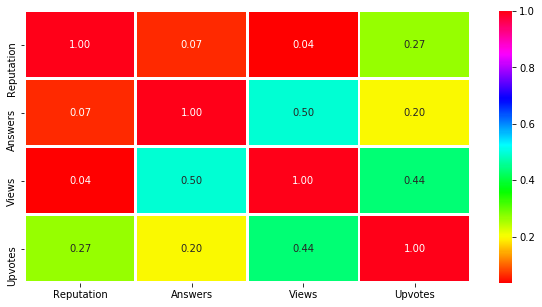

In [13]:
plt.figure(figsize=(10,5))
sns.heatmap(train.corr(),annot=True,cmap='hsv',fmt='.2f',linewidths=2)
plt.show()

In [14]:
X = train.drop(['Upvotes'],axis=1)
y= train['Upvotes']

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=101)


In [16]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X_train,y_train)
y_pred = LR.predict(X_test)

In [17]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2_score: ', metrics.r2_score(y_test,y_pred))



MAE: 615.0954585681604
MSE: 9088112.732861042
RMSE: 3014.6496865906397
R2_score:  0.2621953895878918


In [18]:
from sklearn.preprocessing import PolynomialFeatures

R2_score = []
RMSE = []
for i in range(1,6):    
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(X_train)
    LR = LinearRegression()
    LR.fit(X_poly,y_train)
    X_ptest=poly_reg.fit_transform(X_test)
    y_pred = LR.predict(X_ptest)
    R2_score.append(metrics.r2_score(y_test,y_pred))
    RMSE.append(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

In [19]:
for i,j in enumerate(R2_score):
    print('Polynomial Regression model with degree {} has R squared value as {} and RMSE values as {}'.format(i+1,j,RMSE[i]))

Polynomial Regression model with degree 1 has R squared value as 0.2621953895878819 and RMSE values as 3014.6496865906597
Polynomial Regression model with degree 2 has R squared value as 0.8601137765992515 and RMSE values as 1312.6642064586792
Polynomial Regression model with degree 3 has R squared value as 0.8878612317978827 and RMSE values as 1175.2873481608751
Polynomial Regression model with degree 4 has R squared value as 0.7734080239401236 and RMSE values as 1670.6613819918102
Polynomial Regression model with degree 5 has R squared value as -9.355934559141295 and RMSE values as 11294.339004119109


In [20]:
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)
LR = LinearRegression()
LR.fit(X_poly,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [4]:
test = pd.read_csv("test_8i3B3FC.csv")
test.head()

,ID,Tag,Reputation,Answers,Username,Views
0,366953,a,5645.0,3.0,50652,33200.0
1,71864,c,24511.0,6.0,37685,2730.0
2,141692,i,927.0,1.0,135293,21167.0
3,316833,i,21.0,6.0,166998,18528.0
4,440445,i,4475.0,10.0,53504,57240.0


In [5]:
test.shape

(141448, 6)

In [21]:
test_set_X = test[['Reputation','Answers','Views']]

In [22]:
test_poly = poly_reg.fit_transform(test_set_X)
test_set_upvotes = LR.predict(test_poly)

In [24]:
final_df = pd.concat([test['ID'],pd.DataFrame(np.round(test_set_upvotes),columns=['Upvotes'],dtype=int)],axis=1)

In [25]:
final_df.head()

,ID,Upvotes
0,366953,208
1,71864,3
2,141692,35
3,316833,24
4,440445,267


In [26]:
final_df.to_csv("Test_Output.csv", index=False)

In [6]:
sub = pd.read_csv("sample_submission_OR5kZa5.csv")
sub.head()

,ID,Upvotes
0,7,500
1,9,500
2,12,500
3,13,500
4,16,500
